# Analytics notebooks for the MetaCartel DAO
This notebook should serve as an example on how to analyse the interaction network between members of the MetaCartel DAO around the different proposals offered.

In [1]:
from datetime import datetime
import pandas as pd
import networkx as nx
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
from datetime import datetime

## Define helper functions

This section covers the definition of helper functions for the rest of the notebook.

In [2]:
# Grabbed from https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy
def gini(x):
    mad = np.abs(np.subtract.outer(x, x)).mean()
    rmad = mad/np.mean(x)
    g = 0.5 * rmad
    return g

In [3]:
# from https://medium.com/codex/10-best-resources-to-fetch-cryptocurrency-data-in-python-8400cf0d0136
def get_crypto_price(symbol, exchange, start_date = None):
    api_key = 'YOUR API KEY'
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

In [4]:
def computePayement(row):
    p = row['paymentRequested']
    if row['paymentTokenDecimals']:
        dec = int(row['paymentTokenDecimals'])
        trailingZeros = 0
        for i in range(len(p)):
            if p[-i] == '0':
                trailingZeros += 1
                
        if trailingZeros < dec:
            p = float(p[:len(p)-trailingZeros])
            p = p/(10*(dec-trailingZeros))
        else:
            p = float(p[:len(p)-dec])
        
        return int(p)
    else:
        return 0

## Loading the Dataset
The dataset is going to be loaded into two different type of object for the ease of manipulation, pandas dataframes and network from metworkx. 

In [5]:
with open("./data/13316507-results.json", "r") as f:
    results_09282021 = json.load(f)
f.close()

In [6]:
df_members = pd.DataFrame.from_dict(results_09282021['data']['moloches'][0]['members'])
df_proposals = pd.DataFrame.from_dict(results_09282021['data']['moloches'][0]['proposals'])

In [7]:
df_proposals['paymentRequestedValue']  = df_proposals.apply(computePayement, axis=1)

In [8]:
df_members.head()

,createdAt,didRagequit,id,jailed,kicked,loot,shares
0,1602009236,False,0x4570b4faf71e23942b8b9f934b47ccedf7540162-mem...,None,False,0,0
1,1584524154,False,0x4570b4faf71e23942b8b9f934b47ccedf7540162-mem...,None,False,0,4000
2,1595981957,False,0x4570b4faf71e23942b8b9f934b47ccedf7540162-mem...,None,False,0,0
3,1587695459,False,0x4570b4faf71e23942b8b9f934b47ccedf7540162-mem...,243,True,0,0
4,1593551488,False,0x4570b4faf71e23942b8b9f934b47ccedf7540162-mem...,None,False,0,250


In [9]:
df_proposals.head()

,aborted,actions,applicant,cancelled,cancelledAt,createdAt,delegateKey,details,didPass,escrow,...,tributeTokenDecimals,tributeTokenSymbol,uberHausMinionExecuted,votes,votingPeriodEnds,votingPeriodStarts,whitelist,yesShares,yesVotes,paymentRequestedValue
0,None,[],0x512e07a093aaa20ba288392eadf03838c7a4e522,False,None,1581731640,0x512e07a093aaa20ba288392eadf03838c7a4e522,VENTURE DAO RISES,True,None,...,18,WETH,None,"[{'createdAt': '1582190771', 'id': '0x4570b4fa...",1582349572,1581744772,False,1,1,0
1,None,[],0x4444444477eb5fe6d1d42e98e97d9c4c03a57f99,True,1589824612,1582350195,0x4444444477eb5fe6d1d42e98e97d9c4c03a57f99,Garrett,False,None,...,18,WETH,None,[],0,0,False,0,0,0
2,None,[],0xe2a82cdccbfa6ebf9817b0c4aed45264bd41fbec,False,None,1582922436,0xe2a82cdccbfa6ebf9817b0c4aed45264bd41fbec,kenny rowe,True,None,...,18,WETH,None,"[{'createdAt': '1583449277', 'id': '0x4570b4fa...",1583940772,1583335972,False,1,1,0
3,None,[],0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,False,None,1594507874,0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,"{""id"":""81X6E73Bo"",""title"":""MCV03 Claims tokens...",True,None,...,18,MCV03,None,"[{'createdAt': '1594703956', 'id': '0x4570b4fa...",1595122372,1594517572,False,4700,4,0
4,None,[],0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,False,None,1594508900,0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,"{""id"":""rBtdnWfKP"",""title"":""MCV04 claims token ...",True,None,...,18,MCV04,None,"[{'createdAt': '1594704017', 'id': '0x4570b4fa...",1595280772,1594675972,False,4700,4,0


### Getting the price data for the used tokens

In [10]:
np.unique([i for i in df_proposals['paymentTokenSymbol'].values if i])

array(['DAI', 'MAGIC', 'MCV06', 'MCV07', 'MCV08', 'MCV09', 'MCV10',
       'MCV11', 'MCV12', 'MCV24', 'MCV25', 'MCV26', 'MCV27', 'MCV28',
       'MCV29', 'MCV30', 'MCV31', 'MCV32', 'MCV33', 'MCV34', 'MCV35',
       'RAI', 'STAKE', 'USDC', 'WETH'], dtype='<U5')

In [11]:
validTokens = ['DAI', 'WETH', 'USDC', 'RAI', 'STAKE']

In [12]:
def open_coinmarketcap_price(path):
    with open(path) as f:
        RAW = json.load(f)
    index = []
    data = []
    for ts in RAW['data']['points']:
        index.append(datetime.fromtimestamp(int(ts)))
        data.append(float(RAW['data']['points'][ts]['v'][0]))
    prices = pd.DataFrame(data, index=index, columns=["USD"])
    return prices

rai_prices = open_coinmarketcap_price('./data/RAI_price.json')
dai_prices = open_coinmarketcap_price('./data/DAI_price.json')
eth_prices = open_coinmarketcap_price('./data/ETH_price.json')
magic_prices = open_coinmarketcap_price('./data/MAGIC_price.json')
stake_prices = open_coinmarketcap_price('./data/STAKE_price.json')

In [13]:
# This is dirty, but I don't have the time to get a real API to do this
# So I got the price from coinMarketCap sucking the json that's sent to the graphs

def getUSDprice(row):
    d = datetime.fromtimestamp(int(row['createdAt']))
    prices = []
    if row['paymentTokenSymbol'] == 'WETH':
        prices = eth_prices
    if row['paymentTokenSymbol'] == 'DAI':
        prices = dai_prices
    if row['paymentTokenSymbol'] == 'RAI':
        prices = rai_prices
    if row['paymentTokenSymbol'] == 'MAGIC':
        prices = magic_prices
        return 1 # This is because I can't find data for MAGIC token PRE 2021 ... 
    if row['paymentTokenSymbol'] == 'STAKE':
        prices = stake_prices
    if len(prices) > 0:
        p = row['paymentRequestedValue'] * prices[d.strftime("%Y-%m-%d"):d.strftime("%Y-%m-%d")]['USD'].values[0]
        return p
    else:
        return 0

In [14]:
df_proposals['paymentRequestedUSD'] = df_proposals.apply(getUSDprice, axis=1)

In [15]:
gini(df_members['shares'].astype(int).values)

0.7141136715085616

### Creating the BiPartite network 
Getting the Proposal to User BiPartite Network from the data. This network will be usefull for community detection as well as understanding the voting behaviors.

In [16]:
G = nx.Graph()

In [17]:
def addMember(member):
    G.add_node(member['id'][50:60], fullId=member['id'], nodeType="member", kicked=member['kicked'], shares=int(member['shares']), didRagequit=member['didRagequit'])
    return member['id'][50:60]

def addProposal(proposal):
    G.add_node(proposal['id'][43:], fullId=proposal['id'], nodeType="proposal", yesShares=int(proposal['yesShares']), yesVotes=int(proposal['yesVotes']), applicant=proposal['applicant'], didPass=proposal['didPass'], newMember=proposal['newMember'], payement=proposal['paymentRequestedUSD'])
    for vote in proposal['votes']:
        voter = vote['id'][50:60]
        if vote['uintVote'] == 1:
            opinion = "Yes"
        else:
            opinion = "No"
        createdAt = datetime.fromtimestamp(int(vote['createdAt']))
        G.add_edge(voter, proposal['id'][43:], opinion=opinion, createdAt=createdAt, uintVote=vote['uintVote'])
    return proposal['id'][43:]

In [18]:
# Adding the member from the members list in the case where a member would have never voted, we still want it in the Graph
# Also we can load the metadata in the network that way.
members = df_members.apply(addMember, axis=1).values
proposals = df_proposals.apply(addProposal, axis=1).values

In [19]:
pos = nx.bipartite_layout(G, proposals)

In [20]:
colors = []
for node in G.nodes():
    if G.nodes[node]['nodeType'] == "proposal":
        colors.append("#cc00cc")
    else:
        colors.append("#cccc00")        

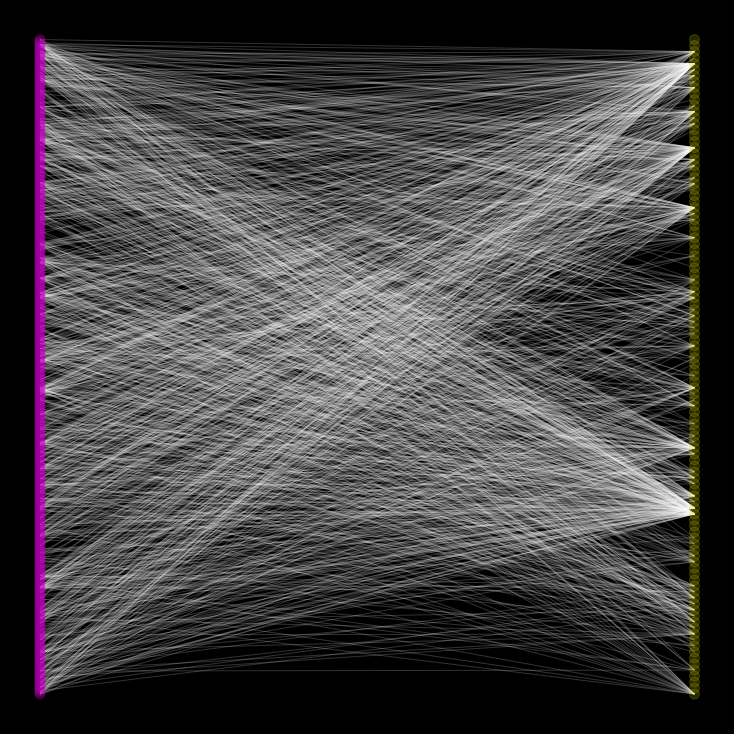

In [21]:
fig = plt.figure(figsize=(10,10))
nx.draw(G, pos=pos, node_size=100, alpha=0.2, node_color=colors, edge_color="white")
fig.patch.set_facecolor('black')

### Project the User Network from the BiPartite

In [22]:
Gproj = nx.bipartite.projected_graph(G, members)

In [23]:
pos = nx.spring_layout(Gproj, k=3)

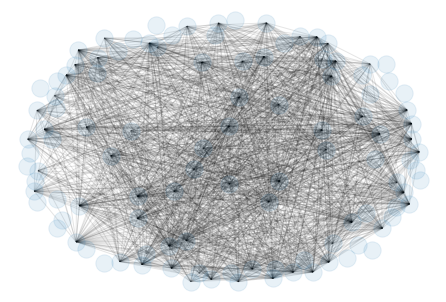

In [24]:
nx.draw(Gproj, pos=pos, alpha=0.1)

As expected this is not super informative in itself, let's try to compute the communities from this graph

In [25]:
import community as community_louvain
import matplotlib.cm as cm

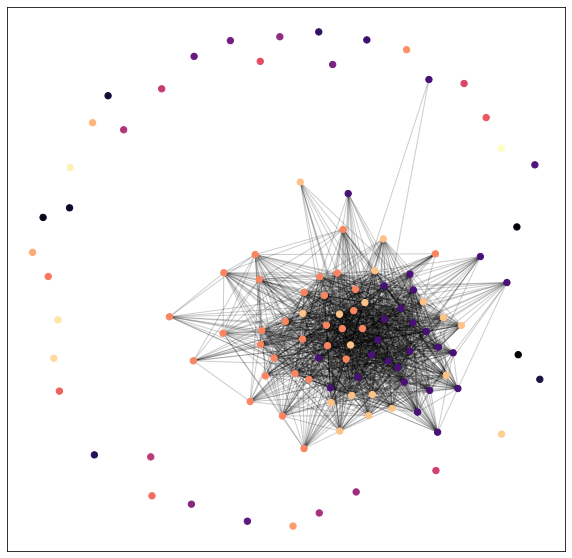

In [26]:
#first compute the best partition
partition = community_louvain.best_partition(Gproj)

# draw the graph
fig = plt.figure(figsize=(10,10))

pos = nx.spring_layout(Gproj, k=1)
# color the nodes according to their partition
cmap = cm.get_cmap('magma', max(partition.values()) + 1)
nx.draw_networkx_nodes(Gproj, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))

nx.draw_networkx_edges(Gproj, pos, alpha=0.2, edge_color="black")

plt.show()


Let's keep only the LCC of the network to remove the members that are not participating

In [27]:
largest_cc = max(nx.connected_components(Gproj), key=len)

In [28]:
GprojLCC = Gproj.subgraph(largest_cc).copy()

In [29]:
deg = nx.degree(GprojLCC)

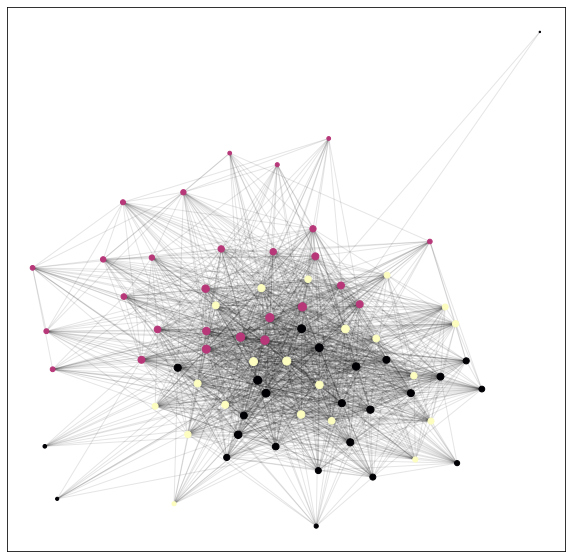

In [30]:
#first compute the best partition
partition = community_louvain.best_partition(GprojLCC)

# draw the graph
fig = plt.figure(figsize=(10,10))

sizes = [deg[node] for node in GprojLCC.nodes()]
pos = nx.spring_layout(GprojLCC)
# color the nodes according to their partition
cmap = cm.get_cmap('magma', max(partition.values()) + 1)
nx.draw_networkx_nodes(GprojLCC, pos, partition.keys(), node_size=sizes,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(GprojLCC, pos, alpha=0.1)
plt.show()

# Insights

Ok now we are starting to get some insights, we can see that there are 3 main community participating differently to the proposals

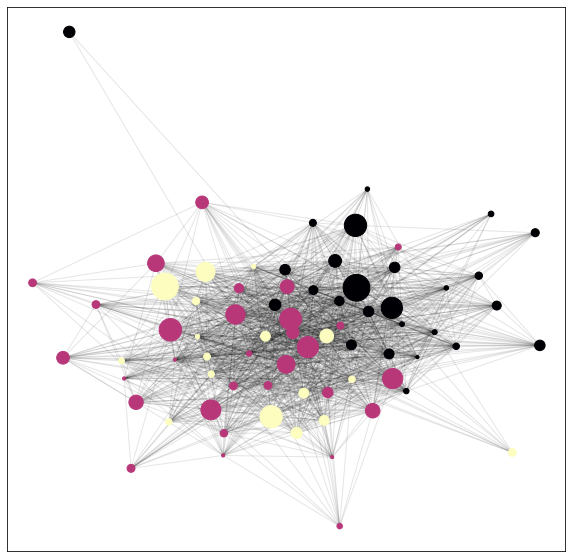

In [31]:
sizes = np.array([GprojLCC.nodes[node]['shares'] for node in GprojLCC.nodes()])

#first compute the best partition
partition = community_louvain.best_partition(GprojLCC)

# draw the graph
fig = plt.figure(figsize=(10,10))

pos = nx.spring_layout(GprojLCC)
# color the nodes according to their partition
cmap = cm.get_cmap('magma', max(partition.values()) + 1)
nx.draw_networkx_nodes(GprojLCC, pos, partition.keys(), node_size=10+sizes/10,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(GprojLCC, pos, alpha=0.1)
plt.show()

# Insights
Ok that's nice, the communities actually seem fairly equal in shares. Let's test this quickly

## Different projections

Here I look at the fact that we can easily filter by proposal type as a Proof of Concept

In [32]:
keep = []
for proposal in proposals:
    ID = G.nodes[proposal]['fullId']
    if df_proposals[df_proposals['id'] == ID]['newMember'].values[0]:
        keep.append(proposal)

In [33]:
# This is the graph of kept proposals + members
subG = nx.subgraph(G, keep + members)

In [34]:
subGproj = nx.bipartite.projected_graph(G, members)

In [35]:
largest_cc = max(nx.connected_components(subGproj), key=len)

In [36]:
subGproj = subGproj.subgraph(largest_cc).copy()

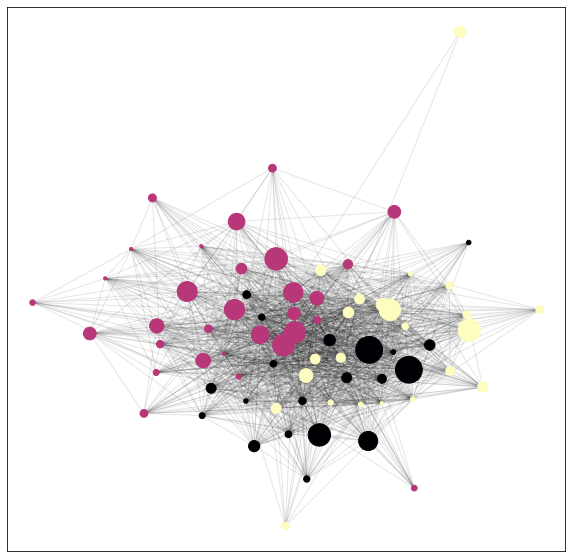

In [37]:
sizes = np.array([subGproj.nodes[node]['shares'] for node in subGproj.nodes()])

#first compute the best partition
partition = community_louvain.best_partition(subGproj)

# draw the graph
fig = plt.figure(figsize=(10,10))

pos = nx.spring_layout(subGproj)
# color the nodes according to their partition
cmap = cm.get_cmap('magma', max(partition.values()) + 1)
nx.draw_networkx_nodes(subGproj, pos, partition.keys(), node_size=10+sizes/10,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(subGproj, pos, alpha=0.1)
plt.show()

## Insight
This is the newMember action graph

Basically, any projection from the bipartite can be easily generated, as long as some criteria on the proposals too keep are decided.

## Looking at summary statistics of the whole dataset

In [38]:
sns.set()

In [39]:
shares = []
for node in GprojLCC.nodes():
    shares.append([partition[node], GprojLCC.nodes[node]['shares']])

In [40]:
df = pd.DataFrame(shares, columns=["partition", "shares"])

<AxesSubplot:xlabel='partition', ylabel='shares'>

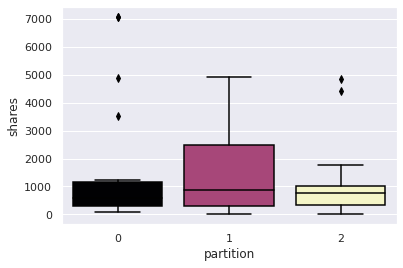

In [41]:
sns.boxplot(data=df, x="partition", y="shares", palette=[cmap(0), cmap(1), cmap(2)])

So, yes to some extent ... but one partition actually has more shares, even if the big holders of the partitions bring the whole up.

Just out of curiosity, are they all voting the same amount

In [42]:
communities = {}
for node in GprojLCC.nodes():
    if partition[node] not in communities:
        communities[partition[node]] = []
    communities[partition[node]].append((node))

In [43]:
voteCounts = []
for community in communities:
    for member in communities[community]:
        voteCounts.append([community, len(G[member])])
df = pd.DataFrame(voteCounts, columns=["partition", "voteCount"]) 

<AxesSubplot:xlabel='partition', ylabel='voteCount'>

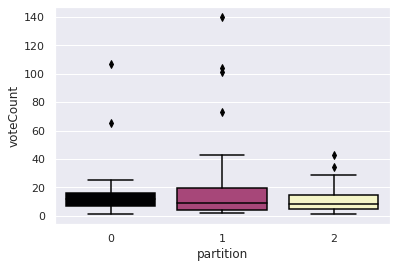

In [44]:
sns.boxplot(data=df, x="partition", y="voteCount", palette=[cmap(0), cmap(1), cmap(2)])

In [45]:
opinions = []
for community in communities:
    for member in communities[community]:
        yes = len([i for i in G[member] if G[member][i]['opinion'] == "Yes"])
        no = len([i for i in G[member] if G[member][i]['opinion'] == "No"])
        opinions.append([community, "Yes", yes])
        opinions.append([community, "No", no])
df = pd.DataFrame(opinions, columns=["partition", "opinion", "count"]) 

<AxesSubplot:xlabel='partition', ylabel='count'>

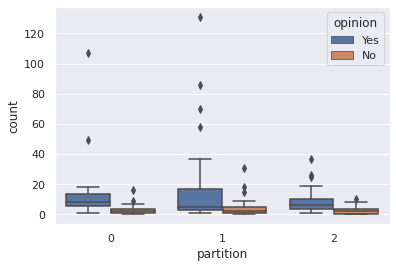

In [46]:
sns.boxplot(data=df, x="partition", y="count", hue="opinion")

In [47]:
df.groupby(['partition','opinion']).sum()

count
partition opinion       
0         No          65
          Yes        308
1         No         134
          Yes        558
2         No          56
          Yes        215

There is quite some no's in this dataset, that's actually really nice!

## Curiosity question: Does having more shares means you participate more (incentive)

In [48]:
X, Y = [], []
for node in GprojLCC.nodes():
    X.append(GprojLCC.nodes[node]['shares'])
    Y.append(deg[node])

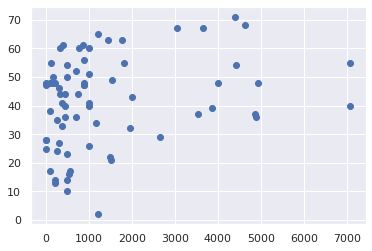

In [49]:
plt.plot(X, Y, 'o')

## Insight
Yes to some extent, having more share means you'll vote more, but this needs a proper analysis though.

# Question: Is a proposal more likely to be refused if it has a paiment attached

In [50]:
voteCounts = []
yesVotes = []
yesProp = []
payment = []
for proposal in proposals:
    if len(G[proposal]):
        voteCounts.append(len(G[proposal]))
        yesVotes.append(G.nodes[proposal]['yesVotes'])
        payment.append(G.nodes[proposal]['payement'])
        yesProp.append(G.nodes[proposal]['yesVotes']/len(G[proposal]))

<ipython-input-51-c1e8dd90380a>:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(payment), yesProp, 'o')


(0.0, 20.0)

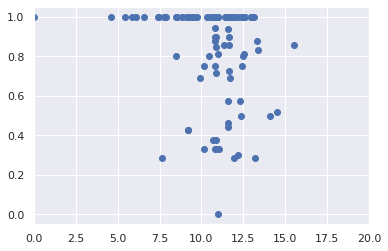

In [51]:
plt.plot(np.log(payment), yesProp, 'o')
plt.xlim(0,20)

## Insight
Interesting, so its not clear that the amount of money attached correlates with a refusal or an increase in down votes... 

In [52]:
data = pd.DataFrame(np.array([voteCounts, yesVotes, yesProp, payment]).T, columns=["voteCounts", "yesVotes", "yesProp", "payment"])

In [53]:
data["hasPayment"] = data['payment']>0

<AxesSubplot:xlabel='hasPayment', ylabel='yesProp'>

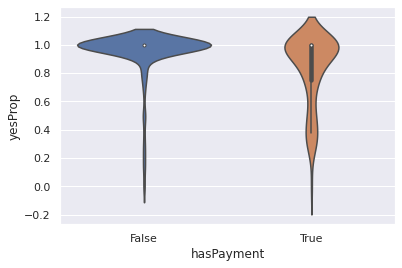

In [54]:
sns.violinplot(data=data, x="hasPayment", y="yesProp")

<AxesSubplot:xlabel='hasPayment', ylabel='voteCounts'>

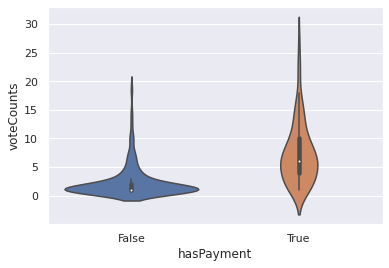

In [55]:
sns.violinplot(data=data, x="hasPayment", y="voteCounts")

## Insight
Yes, so definitely, having a payment attached drags the yes vote down into refusal. Might be trivial but its still nice to see it in the data. 

# Conclusion

So, it seems that this DAO clearly has a vibrant activity, there's a lot of consent and dissent and, there seems to exist 3 community within the User to Proposal participation network. Now, the question is wether those communities are actually representative of something real in the data, or if its more of an artefact?

Some interesting aspects are that they seem to be fairly balanced in term of participation and of shares. 

From a simple curiosity perspective I've asked a few summary statistics as well about voting behavior based on metadata. It looks like the fact that a proposal has a payment attached is a strong incentive to get people to vote, and that this induces more dissent in term of voting behavior. 

I did not try to get a pretty network out of this though, but that's better done in Gephi or Cytoscape anyhow.

Also, I demonstrate how one can filter based on proposal types, but did not really explore it further.

# Ideas
So I think what could be nice next would be to look at wether the communities would "fight":
- If a member of Community A creates a proposal, what does B and C do on average
- Are votes reversed based on the communities? Or is it random?

Also, I want to look at the number of proposal correlate to the number of shares through an ROC curve analysis!